# Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm

from khan_helpers import Experiment
from khan_helpers.constants import (
    CORRECT_ANSWER_COLOR, 
    FIG_DIR, 
    INCORRECT_ANSWER_COLOR
)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/opt/conda/lib/python3.9/site-packages/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Define some helper functions

In [2]:
def bootstrap_ci(M, ci=95, n_boots=1000, random_state=None):
    """
    Estimate a confidence interval for a given 1D array of observations, 
    or for each row of a 2D array.    
    """
    np.random.seed(random_state)
    M = np.atleast_2d(np.asarray(M))
    rand_ixs = np.random.randint(0, M.shape[1], size=(*M.shape, n_boots))
    boot_means = np.take_along_axis(M[:, np.newaxis], rand_ixs, axis=2).mean(axis=1)
    ci_low = np.percentile(boot_means, (100 - ci) / 2, axis=1)
    ci_high = np.percentile(boot_means, (ci + 100) / 2, axis=1)
    return [ci_low.item(), ci_high.item()]

# Compute proportion correct as a function of distance from a reference question

# <span style="color:red">TODO: exclude question 38 (index 37) from analysis? No non-zero weights</span>

In [3]:
exp = Experiment()

dist_bins = np.linspace(0, 2, 21)
err_ribbon_alpha = 0.2

In [4]:
datalist = []

pbar = tqdm(total=len(exp.all_data)*len(dist_bins), leave=False)

for quiz in range(1, 4):
    for p in exp.participants:
        subid = p.subID
        # data for questions from given quiz
        quiz_data = p.get_data(quiz=quiz-1)
        # accuracy for each question on the quiz
        quiz_accuracies = quiz_data['accuracy']
        # simple proportion correct for the quiz
        quiz_prop_correct = quiz_accuracies.sum() / len(quiz_accuracies)
        # topic vectors for questions from the quiz
        quiz_questions_vecs = exp.question_vectors[quiz_data['qID'] - 1]
        # (correlation) distance matrix for questions on the quiz  
        quiz_questions_dists = cdist(quiz_questions_vecs, quiz_questions_vecs, 'correlation')
        # fix some floating point errors in cdist -- diag should be all 0's
        np.fill_diagonal(quiz_questions_dists, 0)

        # loop over questions on the quiz
        for question_ix in range(len(quiz_questions_dists)):
            qid = quiz_data['qID'].iloc[question_ix]
            # accuracy for given question
            question_accuracy = quiz_accuracies.iloc[question_ix]
            # (correlation) distance between given question and all 
            # questions on the quiz (including itself)
            question_dists = quiz_questions_dists[question_ix]

            # loop over bins (max distances within which to consider questions)
            for max_dist in dist_bins:
                # accuracy on questions within max_dist of reference question
                acc_within_dist = quiz_accuracies[question_dists <= max_dist]
                # number of questions within max_dist of reference question
                n_within_dist = len(acc_within_dist)
                if n_within_dist == 0:
                    # sanity check
                    raise RuntimeError

                datalist.append({
                    'quiz': quiz,
                    'participant': subid,
                    'raw_prop_correct': quiz_prop_correct,
                    'reference_question': qid,
                    'accuracy': question_accuracy,
                    'max_dist': max_dist,
#                     'n_within_dist': n_within_dist,
                    'prop_correct': acc_within_dist.sum() / n_within_dist
                })
                pbar.update()

pbar.close()
df_initial = pd.DataFrame(datalist)
df_initial

  0%|          | 0/40950 [00:00<?, ?it/s]

,quiz,participant,raw_prop_correct,reference_question,accuracy,max_dist,prop_correct
0,1,P1,0.538462,13,1,0.0,1.000000
1,1,P1,0.538462,13,1,0.1,1.000000
2,1,P1,0.538462,13,1,0.2,1.000000
3,1,P1,0.538462,13,1,0.3,1.000000
4,1,P1,0.538462,13,1,0.4,0.500000
...,...,...,...,...,...,...,...
40945,3,P50,0.692308,20,1,1.6,0.692308
40946,3,P50,0.692308,20,1,1.7,0.692308
40947,3,P50,0.692308,20,1,1.8,0.692308
40948,3,P50,0.692308,20,1,1.9,0.692308


# Find distance beyond which knowledge of a particular question predicts knowledge of another question no better than overall proportion correct

In [5]:
# average over questions within participants for each quiz & distance 
# bin, split by whether the reference question was answered correctly or 
# incorrectly
sub_avg_df = (
    df_initial
    .groupby(['quiz', 'participant', 'accuracy', 'max_dist'], as_index=False)
    .mean()
    # drop raw_prop correct for now and recompute later, since that's 
    # constant across bins and correctness
#     .drop(columns=['raw_prop_correct', 'reference_question', 'n_within_dist'])
    .drop(columns=['raw_prop_correct', 'reference_question'])
)
sub_avg_df

,quiz,participant,accuracy,max_dist,prop_correct
0,1,P1,0,0.0,0.000000
1,1,P1,0,0.1,0.222222
2,1,P1,0,0.2,0.222222
3,1,P1,0,0.3,0.222222
4,1,P1,0,0.4,0.388889
...,...,...,...,...,...
6190,3,P9,1,1.6,0.769231
6191,3,P9,1,1.7,0.769231
6192,3,P9,1,1.8,0.769231
6193,3,P9,1,1.9,0.769231


In [6]:
# compute across-participants mean & 95% CI for p(correct) for each 
# quiz & distance bin, split by reference question correctness
pcorrect_grouper = sub_avg_df.groupby(['quiz', 'accuracy', 'max_dist'])
pcorrect_means = pcorrect_grouper['prop_correct'].mean()
pcorrect_means

quiz  accuracy  max_dist
1     0         0.0         0.000000
                0.1         0.083276
                0.2         0.155203
                0.3         0.161188
                0.4         0.192190
                              ...   
3     1         1.6         0.784615
                1.7         0.784615
                1.8         0.784615
                1.9         0.784615
                2.0         0.784615
Name: prop_correct, Length: 126, dtype: float64

In [8]:
pcorrect_cis = pcorrect_grouper['prop_correct'].agg(bootstrap_ci).tolist()
pcorrect_cis
# pd.DataFrame(pcorrect_cis, columns=('ci_low', 'ci_high'), index=pcorrect_means.index)

[[0.0, 0.0],
 [0.06338174302549301, 0.10274025673400673],
 [0.13004301346801347, 0.1817102062289562],
 [0.13176671386483887, 0.1904460362554113],
 [0.15861453553391053, 0.2260549347643097],
 [0.1809052543290043, 0.2485247667147667],
 [0.18718373556998552, 0.2625915836940837],
 [0.20028521133958632, 0.2709909322390572],
 [0.22741803511303513, 0.29849079184704186],
 [0.24034652928090428, 0.3153801813629493],
 [0.31350774842551626, 0.39263082812689937],
 [0.38031914997971006, 0.47351561814858634],
 [0.4091898621370214, 0.5060272258255213],
 [0.407653846153846, 0.5061538461538462],
 [0.406153846153846, 0.506153846153846],
 [0.4092307692307691, 0.5030769230769232],
 [0.40765384615384614, 0.5015384615384615],
 [0.40923076923076906, 0.5046153846153845],
 [0.403076923076923, 0.5046153846153844],
 [0.40457692307692306, 0.5015384615384617],
 [0.4076923076923076, 0.5061538461538462],
 [1.0, 1.0],
 [0.8529813943001442, 0.9084955266955267],
 [0.7693458664021161, 0.8413771404521402],
 [0.76162595298

In [9]:
# compute across-participant mean & 95% CI for overall p(correct)
# drop duplicates to properly compute confidence intervals
raw_pcorrect_grouper = df_initial.drop_duplicates(('quiz', 'participant', 'raw_prop_correct')).groupby('quiz')
raw_pcorrect_means = raw_pcorrect_grouper['raw_prop_correct'].mean()
raw_pcorrect_means

quiz
1    0.455385
2    0.603077
3    0.784615
Name: raw_prop_correct, dtype: float64

In [10]:
raw_pcorrect_cis = raw_pcorrect_grouper['raw_prop_correct'].agg(bootstrap_ci)
raw_pcorrect_cis

quiz
1     [0.406153846153846, 0.5030769230769231]
2     [0.556923076923077, 0.6508076923076928]
3    [0.7476923076923078, 0.8230769230769229]
Name: raw_prop_correct, dtype: object

In [ ]:
def compute_ci_intersections(correct_cis, incorrect_cis, raw_cis, interp_freq=None):
    """
    Compute the minimum x-value (distance from reference question) at 
    which the confidence intervals for by-distance p(correct) and 
    raw/overall p(correct) intersect. 
    
    Parameters
    ----------
    correct_cis, incorrect_cis : array_like
        Iterable of across-participants confidence intervals for the 
        mean p(correct) at each distance value. Each item should be an 
        iterable of length two: (ci_low, ci_high). `correct_cis` and 
        `incorrect_cis` correspond to correctly and incorrectly answered 
        reference questions.
    raw_cis : array_like
        The confidence interval for the mean raw/overall proportion 
        correct as a single iterable of length two (ci_low, ci_high).
        
    interp_freq : float, optional
        If provided, interpolate the series of by-distance confidence 
        intervals to the given frequency before computing intersections
        
    Returns
    -------
    tuple of float
        The minimum distances at which the confidence intervals for 
        by-distance p(correct) and raw p(correct) intersect. The first 
        value corresponds to `correct_cis`; the second corresponds to 
        `incorrect_cis`.
    """
    correct_cis_low, correct_cis_high = np.asarray(correct_cis).T
    incorrect_cis_low, incorrect_cis_high = np.asarray(incorrect_cis).T
    raw_ci_low, raw_ci_high = raw_cis
    
    if interp_freq is not None:
        ...
    else:
        dist_vals = dist_bins
        
    correct_intersect = None
    incorrect_intersec = None
    
    for ix, dist in enumerate(dist_vals):
        if 

In [13]:
test = pd.DataFrame(pcorrect_cis, columns=('ci_low', 'ci_high'), index=pcorrect_means.index)
test

ci_low   ci_high
quiz accuracy max_dist                    
1    0        0.0       0.000000  0.000000
              0.1       0.063382  0.102740
              0.2       0.130043  0.181710
              0.3       0.131767  0.190446
              0.4       0.158615  0.226055
...                          ...       ...
3    1        1.6       0.746154  0.821538
              1.7       0.743077  0.820000
              1.8       0.746154  0.821538
              1.9       0.746154  0.821538
              2.0       0.746115  0.821538

[126 rows x 2 columns]

In [24]:
test.loc[(1, 0), 'ci_low'].values

array([0.        , 0.06338174, 0.13004301, 0.13176671, 0.15861454,
       0.18090525, 0.18718374, 0.20028521, 0.22741804, 0.24034653,
       0.31350775, 0.38031915, 0.40918986, 0.40765385, 0.40615385,
       0.40923077, 0.40765385, 0.40923077, 0.40307692, 0.40457692,
       0.40769231])

'1.3.5'

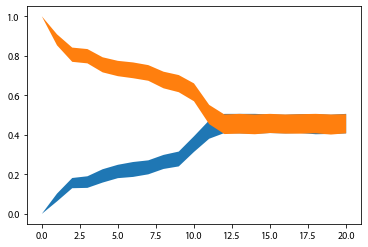

In [21]:
plt.fill_between(range(21), *test.loc[(1, 0)].to_numpy().T)
plt.fill_between(range(21), *test.loc[(1, 1)].to_numpy().T)

In [111]:
a, b = np.asarray(pcorrect_cis).T

In [106]:
# average over quiz questions within participants
grouped_df = (df_initial
              .groupby(['quiz', 'participant', 'accuracy', 'max_dist'], as_index=False)
              .mean()
              .drop(columns=['reference_question', 'n_within_dist']))

# group data for across-participants calculations
grouper = grouped_df.groupby(['quiz', 'accuracy', 'max_dist'])

# across-participants average by-distance p(correct) & raw p(correct) 
# for each quiz/accuracy/max_dist combination
prop_correct_means = (grouper[['prop_correct', 'raw_prop_correct']]
                      .mean()
                      .reset_index(drop=True))

# confidence intervals for by-distance p(correct) & raw p(correct)
df_agg_ci = (grouper[['prop_correct', 'raw_prop_correct']]
             .agg(bootstrap_ci)
             .reset_index())
ci_cols = pd.DataFrame(df_agg_ci['prop_correct'].tolist(), 
                       columns=('ci_low', 'ci_high'))
raw_ci_cols = pd.DataFrame(df_agg_ci['raw_prop_correct'].tolist(), 
                           columns=('raw_ci_low', 'raw_ci_high'))

df = pd.concat(
    (
        df_agg_ci.drop(columns=['prop_correct', 'raw_prop_correct']), 
        prop_correct_means, 
        ci_cols, 
        raw_ci_cols
    ), 
    axis=1
)
df

,quiz,accuracy,max_dist,prop_correct,raw_prop_correct,ci_low,ci_high,raw_ci_low,raw_ci_high
0,1,0,0.0,0.000000,0.455385,0.000000,0.000000,0.409192,0.503115
1,1,0,0.1,0.083276,0.455385,0.065101,0.103244,0.412308,0.506154
2,1,0,0.2,0.155203,0.455385,0.128434,0.182527,0.409231,0.507692
3,1,0,0.3,0.161188,0.455385,0.131112,0.191867,0.406154,0.504654
4,1,0,0.4,0.192190,0.455385,0.162032,0.223880,0.406154,0.503077
...,...,...,...,...,...,...,...,...,...
121,3,1,1.6,0.784615,0.784615,0.744615,0.821538,0.746154,0.820000
122,3,1,1.7,0.784615,0.784615,0.747654,0.821577,0.744615,0.821538
123,3,1,1.8,0.784615,0.784615,0.746154,0.823077,0.744615,0.820000
124,3,1,1.9,0.784615,0.784615,0.744615,0.820000,0.746154,0.823077


In [109]:
df_initial['raw_prop_correct'].nunique(), sorted(df_initial['raw_prop_correct'].unique())

(12,
 [0.15384615384615385,
  0.23076923076923078,
  0.3076923076923077,
  0.38461538461538464,
  0.46153846153846156,
  0.5384615384615384,
  0.6153846153846154,
  0.6923076923076923,
  0.7692307692307693,
  0.8461538461538461,
  0.9230769230769231,
  1.0])

In [110]:
grouped_df['raw_prop_correct'].nunique(), sorted(grouped_df['raw_prop_correct'].unique())

(16,
 [0.15384615384615385,
  0.23076923076923075,
  0.23076923076923078,
  0.3076923076923077,
  0.38461538461538464,
  0.4615384615384615,
  0.46153846153846156,
  0.5384615384615384,
  0.6153846153846154,
  0.6923076923076923,
  0.7692307692307693,
  0.8461538461538461,
  0.8461538461538463,
  0.923076923076923,
  0.9230769230769231,
  1.0])

In [112]:
prop_correct_means['raw_prop_correct'].nunique(), sorted(prop_correct_means['raw_prop_correct'].unique())

(5,
 [0.4553846153846154,
  0.5949764521193093,
  0.6030769230769231,
  0.7658862876254181,
  0.7846153846153847])

In [63]:
def fill_between(data, x, y_low, y_high, alpha=err_ribbon_alpha, **kwargs):
    print(kwargs)
    print(f"{x=}")
    print(f"{y_low=}")
    print(f"{y_high=}")
    from IPython.display import display
    display(data)
#     plt.fill_between

{'color': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)}
x='max_dist'
y_low='ci_low'
y_high='ci_high'


,quiz,accuracy,max_dist,prop_correct,raw_prop_correct,ci_low,ci_high,raw_ci_low,raw_ci_high
0,1,0,0.0,0.000000,0.455385,0.000000,0.000000,0.407654,0.503077
1,1,0,0.1,0.083276,0.455385,0.064266,0.104328,0.404615,0.509231
2,1,0,0.2,0.155203,0.455385,0.127858,0.182778,0.404615,0.501577
3,1,0,0.3,0.161188,0.455385,0.134048,0.188441,0.409192,0.506154
4,1,0,0.4,0.192190,0.455385,0.158094,0.224426,0.409192,0.506154
5,1,0,0.5,0.212387,0.455385,0.179547,0.245266,0.404615,0.503115
6,1,0,0.6,0.226927,0.455385,0.191959,0.263102,0.406154,0.504615
7,1,0,0.7,0.234557,0.455385,0.198698,0.271749,0.406115,0.504615
8,1,0,0.8,0.262663,0.455385,0.226526,0.299435,0.406115,0.507692
9,1,0,0.9,0.277077,0.455385,0.241797,0.314548,0.407654,0.506192


{'color': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)}
x='max_dist'
y_low='ci_low'
y_high='ci_high'


,quiz,accuracy,max_dist,prop_correct,raw_prop_correct,ci_low,ci_high,raw_ci_low,raw_ci_high
42,2,0,0.0,0.000000,0.594976,0.000000,0.000000,0.549451,0.637402
43,2,0,0.1,0.084710,0.594976,0.059092,0.113824,0.551020,0.637402
44,2,0,0.2,0.128247,0.594976,0.096143,0.158509,0.549451,0.640542
45,2,0,0.3,0.157637,0.594976,0.122957,0.195017,0.551020,0.635832
46,2,0,0.4,0.206712,0.594976,0.170964,0.244732,0.550981,0.638932
47,2,0,0.5,0.240081,0.594976,0.202491,0.281948,0.552590,0.638972
48,2,0,0.6,0.251743,0.594976,0.208742,0.294598,0.552590,0.637402
49,2,0,0.7,0.267483,0.594976,0.224432,0.311869,0.550981,0.638932
50,2,0,0.8,0.312708,0.594976,0.268071,0.357005,0.551020,0.642072
51,2,0,0.9,0.329424,0.594976,0.283325,0.378130,0.554121,0.642072


{'color': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)}
x='max_dist'
y_low='ci_low'
y_high='ci_high'


,quiz,accuracy,max_dist,prop_correct,raw_prop_correct,ci_low,ci_high,raw_ci_low,raw_ci_high
84,3,0,0.0,0.000000,0.765886,0.000000,0.000000,0.730727,0.801003
85,3,0,0.1,0.127838,0.765886,0.078125,0.184908,0.729097,0.801003
86,3,0,0.2,0.180072,0.765886,0.125420,0.232856,0.729097,0.801003
87,3,0,0.3,0.195036,0.765886,0.144865,0.246506,0.725753,0.799331
88,3,0,0.4,0.262548,0.765886,0.207729,0.317156,0.729097,0.802717
89,3,0,0.5,0.296679,0.765886,0.243102,0.349579,0.727425,0.801003
90,3,0,0.6,0.315519,0.765886,0.261452,0.369446,0.727383,0.802676
91,3,0,0.7,0.348345,0.765886,0.291972,0.399531,0.730769,0.801003
92,3,0,0.8,0.419514,0.765886,0.368830,0.469979,0.730727,0.802676
93,3,0,0.9,0.460560,0.765886,0.404025,0.511446,0.729097,0.801003


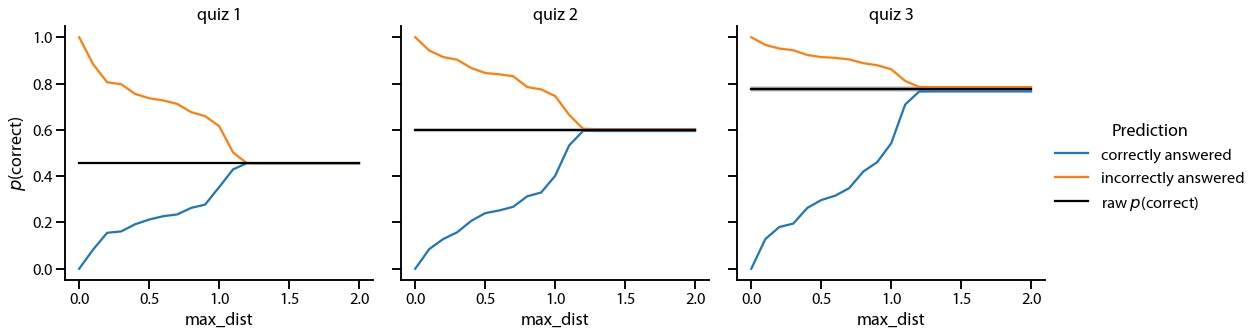

In [64]:
with sns.plotting_context('talk'):
    g = sns.relplot(data=df, x='max_dist', col='quiz')
    g.map_dataframe(sns.lineplot, 
                    x='max_dist', 
                    y='prop_correct', 
                    hue='accuracy')
    g.map_dataframe(sns.lineplot, 
                    x='max_dist', 
                    y='raw_prop_correct', 
                    color='k', 
                    label='raw')
    g.map_dataframe(fill_between,
                    x='max_dist',
                    y_low='ci_low',
                    y_high='ci_high',
                    alpha=err_ribbon_alpha
                   )
#     g.map(plt.fill_between,
#           'max_dist',
#           'ci_low',
#           'ci_high',
#           alpha=err_ribbon_alpha,
#          )
    g.set_titles('{col_var} {col_name}')
    g.set_ylabels('$p$(correct)')
    legend_data = {
        'correctly answered': g._legend_data['0'],
        'incorrectly answered': g._legend_data['1'],
        'raw $p$(correct)': g._legend_data['raw']
    }
    g.add_legend(legend_data, title='Prediction')
#     for ax in g.axes.ravel():
#         (
#             incorrect_ribbon, 
#             correct_ribbon, 
#             pcorrect_ribbon
#         ) = ax.collections[1:4]
#         break
#         for obj in (incorrect_ribbon, correct_ribbon, pcorrect_ribbon):
#             assert len(obj.get_paths()) == 1

#     incorrect_error_ribbon, correct_error_ribbon, pcorrect_error_ribbon = 
#     g.axes[0, 0].collections[1].remove()
    plt.show()

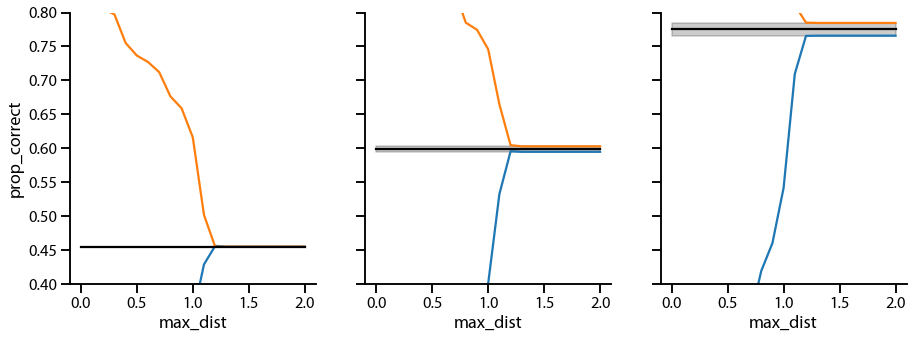

In [103]:
with sns.plotting_context('talk'):
    fig, axarr = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    
    for quiz, ax in enumerate(axarr, start=1):
        quiz_data = df.query('quiz == @quiz')
        sns.lineplot(data=quiz_data, 
                     x='max_dist', 
                     y='prop_correct', 
                     hue='accuracy', 
                     legend=False, 
                     ax=ax)
        sns.lineplot(data=quiz_data, 
                     x='max_dist',
                     y='raw_prop_correct',
                     color='k',
                     ax=ax)
    
    sns.despine(fig)
        

In [100]:
df['raw_prop_correct'].nunique(), df['raw_prop_correct'].unique()

(5, array([0.45538462, 0.59497645, 0.60307692, 0.76588629, 0.78461538]))

In [101]:
df_initial['raw_prop_correct'].nunique(), df_initial['raw_prop_correct'].unique()

(12,
 array([0.53846154, 0.23076923, 0.38461538, 0.46153846, 0.30769231,
        0.61538462, 0.69230769, 0.15384615, 0.76923077, 0.84615385,
        1.        , 0.92307692]))

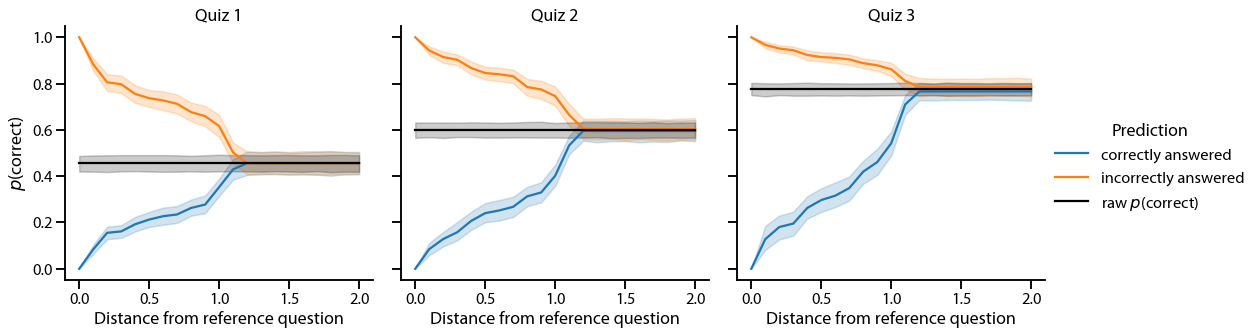

In [13]:
grouped_df = df_initial.groupby(['quiz', 'participant', 'accuracy', 'max_dist'], as_index=False).mean()
data = grouped_df.rename(columns={
    'quiz': 'Quiz', 
    'max_dist': 'Distance from reference question', 
    'prop_correct': '$p$(correct)'
})


with sns.plotting_context('talk'):
    g = sns.relplot(data=data, x='Distance from reference question', col='Quiz')
    g.map_dataframe(sns.lineplot, 
                    x='Distance from reference question', 
                    y='$p$(correct)', 
                    hue='accuracy')
    g.map_dataframe(sns.lineplot, 
                    x='Distance from reference question', 
                    y='raw_prop_correct', 
                    color='k', 
                    label='raw')
    g.set_titles('{col_var} {col_name}')
    g.set_ylabels('$p$(correct)')
    legend_data = {
        'correctly answered': g._legend_data['0'],
        'incorrectly answered': g._legend_data['1'],
        'raw $p$(correct)': g._legend_data['raw']
    }
    g.add_legend(legend_data, title='Prediction')
#     for ax in g.axes.ravel():
#         (
#             incorrect_ribbon, 
#             correct_ribbon, 
#             pcorrect_ribbon
#         ) = ax.collections[1:4]
#         break
#         for obj in (incorrect_ribbon, correct_ribbon, pcorrect_ribbon):
#             assert len(obj.get_paths()) == 1

#     incorrect_error_ribbon, correct_error_ribbon, pcorrect_error_ribbon = 
#     g.axes[0, 0].collections[1].remove()
    plt.show()

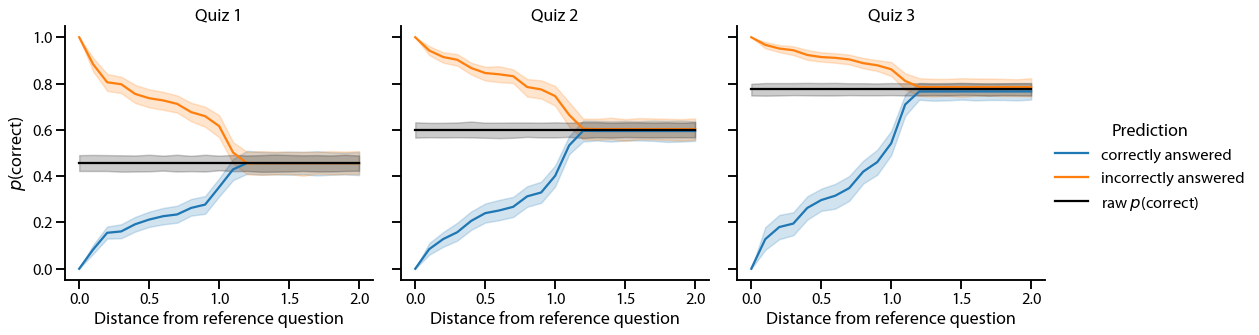

In [10]:
grouped_df = df.groupby(['quiz', 'participant', 'accuracy', 'max_dist'], as_index=False).mean()
data = grouped_df.rename(columns={
    'quiz': 'Quiz', 
    'max_dist': 'Distance from reference question', 
    'prop_correct': '$p$(correct)'
})

with sns.plotting_context('talk'):
    g = sns.relplot(data=data, x='Distance from reference question', col='Quiz')
    g.map_dataframe(sns.lineplot, 
                    x='Distance from reference question', 
                    y='$p$(correct)', 
                    hue='accuracy')
    g.map_dataframe(sns.lineplot, 
                    x='Distance from reference question', 
                    y='raw_prop_correct', 
                    color='k', 
                    label='raw')
    g.set_titles('{col_var} {col_name}')
    g.set_ylabels('$p$(correct)')
    legend_data = {
        'correctly answered': g._legend_data['0'],
        'incorrectly answered': g._legend_data['1'],
        'raw $p$(correct)': g._legend_data['raw']
    }
    g.add_legend(legend_data, title='Prediction')
#     for ax in g.axes.ravel():
#         (
#             incorrect_ribbon, 
#             correct_ribbon, 
#             pcorrect_ribbon
#         ) = ax.collections[1:4]
#         break
#         for obj in (incorrect_ribbon, correct_ribbon, pcorrect_ribbon):
#             assert len(obj.get_paths()) == 1

#     incorrect_error_ribbon, correct_error_ribbon, pcorrect_error_ribbon = 
#     g.axes[0, 0].collections[1].remove()
    plt.show()

In [12]:
# with sns.plotting_context('talk'):
#     g = sns.relplot(data=df.groupby(['quiz', 'participant', 'accuracy', 'max_dist'], 
#                                     as_index=False).mean(),
#                     x='max_dist',
#                     col='quiz')
#     g.map(sns.lineplot, 'max_dist', 'n_within_dist', 'accuracy')
# #     g.map(sns.lineplot, 'max_dist', 'raw_prop_correct', color='k', label='raw')
#     g.set_titles('{col_var} {col_name}')
#     g.set_xlabels('Distance from reference question')
#     g.set_ylabels('number of questions within radius')
#     legend_data = {
#         'correctly answered': g._legend_data['0'],
#         'incorrectly answered': g._legend_data['1'],
# #         'raw $p$(correct)': g._legend_data['raw']
#     }
#     g.add_legend(legend_data, title='Prediction')
#     plt.show()

In [40]:
sns.utils.ci(sns.algorithms.bootstrap(x, n_boot=1000, func=np.mean), which=95)

/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


ValueError: operands could not be broadcast together with shapes (3,) (50,) 

In [41]:
grouped_df.query('')

,quiz,participant,accuracy,max_dist,raw_prop_correct,prop_correct
0,1,P1,0,0.0,0.538462,0.000000
1,1,P1,0,0.1,0.538462,0.222222
2,1,P1,0,0.2,0.538462,0.222222
3,1,P1,0,0.3,0.538462,0.222222
4,1,P1,0,0.4,0.538462,0.388889
...,...,...,...,...,...,...
6190,3,P9,1,1.6,0.769231,0.769231
6191,3,P9,1,1.7,0.769231,0.769231
6192,3,P9,1,1.8,0.769231,0.769231
6193,3,P9,1,1.9,0.769231,0.769231


In [169]:
np.atleast_2d(np.array([1, 2, 3, 4]))

array([1, 2, 3, 4])

In [ ]:
def bootstrap_ci_plot(
    M, 
    ci=95, 
    n_boots=1000, 
    color='#1f77b4', 
    alpha=0.3, 
    return_bounds=False, 
    label=None, 
    ax=None,
    line_kwargs=None,
    ribbon_kwargs=None
):
    """
    Plots a timeseries of observations with error ribbons denoting the 
    bootstrap confidence interval at each timepoint.  Looks very similar 
    to `seaborn.lineplot`, but runs about 2-3 times as fast.
    
    Parameters
    ----------
    M : numpy.ndarray
        A (timepoints, observations) array of values for plotting
    ci : int, optional
        The size of the confidence interval as a percentage (default: 95).
    n_boots : int, optional
        The number of bootstraps to use for computing the confidence 
        interval. Full-size resamples of observations are constructed 
        (with replacement) for each timepoint independently.
    color : str or tuple of float, optional
        Any color specification accepted by Matplotlib.  See 
        https://matplotlib.org/3.1.1/tutorials/colors/colors.html for a 
        full list of options.  Unless otherwise specified in 
        `ribbon_kwargs`, this also sets the color of the CI ribbon.  
        Defaults to the first color in the currently set palette.
    alpha : float, optional
        Alpha value for the CI ribbon (default: 0.3).
    return_bounds : bool, optional
        If True (default: False), return arrays containing the lower and 
        upper bounds of the computed confidence interval for each 
        timepoint in addition to the axis object.
    label : str, optional
        Label assigned to the line if constructing a legend.
    ax : matplotlib.axes.Axes, optional
        The axes on which to draw the plot.  May be a 
        `matplotlib.axes.Axes` object or one of its various subclasses.  
        Defaults to the current Axes.
    line_kwargs : dict, optional
        Additional keyword arguments forwarded to 
        `matplotlib.axes.Axes.plot`.
    ribbon_kwargs : dict, optional
        Additional keyword argumets forwarded to 
        `matplotlib.axes.Axes.fill_between`.

    Returns
    -------
    returns : matplotlib.axes.Axes or list of objects
        Return value depends on the value passed to `return_bounds`. If 
        False (default), the Axes object alone is returned.  If True, a 
        3-tuple is returned, where the first item is the Axes object and 
        the second and third items are 1-D Numpy arrays respectively 
        containing the lower and upper bounds of the confidence interval 
        at each timepoint.

    """
    line_kwargs = {} if line_kwargs is None else line_kwargs
    ribbon_kwargs = {} if ribbon_kwargs is None else ribbon_kwargs
    if color is None:
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    if 'color' not in ribbon_kwargs:
        ribbon_kwargs['color'] = color

    timepoints = np.arange(M.shape[0])
    obs_mean = M.mean(axis=1)
    
    # (n_tpts, n_obs, n_boots) column indices to subsample each row of M
    rand_ixs = np.random.randint(0, M.shape[1], size=(*M.shape, n_boots))
    # (n_tpts, n_boots) subsample means for each timepoint
    boot_means = np.take_along_axis(M[:, np.newaxis], rand_ixs, axis=2).mean(axis=1)
    ci_low = np.percentile(boot_means, (100 - ci) / 2, axis=1)
    ci_high = np.percentile(boot_means, (ci + 100) / 2, axis=1)
    
    if ax is None:
        ax = plt.gca()
    
    ax.fill_between(timepoints, ci_low, ci_high, alpha=alpha, **ribbon_kwargs)
    ax.plot(timepoints, obs_mean, color=color, label=label, **line_kwargs)
    if return_bounds:
        return ax, ci_low, ci_high
    else:
        return ax